In [76]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from helper_functions import *
import seaborn as sns
from scipy.stats import norm
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

# SPZ Mini Challenge 1 
### Data
Für diese Challenge haben wir die Daten von [SwissGrid](www.swissgrid.ch) verwendet, die hier zu finden sind: [Energie Übersicht](https://www.swissgrid.ch/en/home/operation/grid-data/transmission.html). 

Von diesen Daten verwenden wir die 15-Minuten-Auflösung, da dies die einzige Auflösung ist, die alle Informationen enthält, die wir benötigen. Um Rechenzeit zu sparen, werden die Daten auf eine 4-Stunden-Auflösung hochgerechnet. Für bestimmte Aufgaben werden wir eine tägliche oder monatliche Auflösung verwenden.

### Budget, Usage und Bilanz
Um diese Features zu erzeugen, gehen wir wie folgt vor:

#### Budget

Hinzufügen von `"Summe produzierte Energie Regelblock Schweiz"` und `"Import"`
#### Verbrauch

Addition von `"Summe endverbrauchte Energie Regelblock Schweiz"` und `"Export"`
#### Bilanz

Subtraktion von `"Budget"` - `"Verbrauch"`

## Data Loading und  Data Cleaning
In den nächsten Schritten werden wir die Kopfzeilen bereinigen, die Typen bestimmter Spalten festlegen, die Daten abfragen und die neuen Funktionen generieren.

In [3]:
# Read in Data:
data = load_data('EnergieUebersichtCH-*', 'Zeitreihen0h15')
data.head()

,Unnamed: 0,Summe endverbrauchte Energie Regelblock Schweiz\nTotal energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz\nTotal energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz\nNet outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz\nGrid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie\nPositive secundary control energy,Negative Sekundär-Regelenergie\nNegative secundary control energy,Positive Tertiär-Regelenergie\nPositive tertiary control energy,Negative Tertiär-Regelenergie\nNegative tertiary control energy,...,"Produktion Kantone OW, NW, UR\nProduction Cantons OW, NW, UR","Verbrauch Kantone OW, NW, UR\nConsumption Cantons OW, NW, UR","Produktion Kantone GE, VD\nProduction Cantons GE, VD","Verbrauch Kantone GE, VD\nConsumption Cantons GE, VD","Produktion Kantone SH, ZH\nProduction Cantons SH, ZH","Verbrauch Kantone SH, ZH\nConsumption Cantons SH, ZH",Produktion Kantonsübergreifend\nProduction across Cantons,Verbrauch Kantonsübergreifend\nConsumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete\nProduction control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete\nConsumption control area CH - foreign territories
0,Zeitstempel,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01 00:15:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01 00:30:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01 00:45:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01 01:00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Clean Dataframe (Rename columns etc.)
data_clean = data_cleaning(data.copy())
data_clean.head()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Positive Sekundär-Regelenergie,Negative Sekundär-Regelenergie,Positive Tertiär-Regelenergie,Negative Tertiär-Regelenergie,Verbundaustausch CH->AT,...,"Produktion Kantone OW, NW, UR","Verbrauch Kantone OW, NW, UR","Produktion Kantone GE, VD","Verbrauch Kantone GE, VD","Produktion Kantone SH, ZH","Verbrauch Kantone SH, ZH",Produktion Kantonsübergreifend,Verbrauch Kantonsübergreifend,Produktion Regelzone CH - Ausländische Gebiete,Verbrauch Regelzone CH - Ausländische Gebiete
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:15:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:30:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:45:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:15:00,1722372.541,1350111.973,1919922.64075,501786.775,1065655.805,0,-24000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Change from CET to UTC:
data_clean_loc = localize_time(data_clean.copy())
data_clean_loc.head()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Positive Sekundär-Regelenergie,Negative Sekundär-Regelenergie,Positive Tertiär-Regelenergie,Negative Tertiär-Regelenergie,Verbundaustausch CH->AT,...,"Produktion Kantone OW, NW, UR","Verbrauch Kantone OW, NW, UR","Produktion Kantone GE, VD","Verbrauch Kantone GE, VD","Produktion Kantone SH, ZH","Verbrauch Kantone SH, ZH",Produktion Kantonsübergreifend,Verbrauch Kantonsübergreifend,Produktion Regelzone CH - Ausländische Gebiete,Verbrauch Regelzone CH - Ausländische Gebiete
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2008-12-31 23:15:00+00:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31 23:30:00+00:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31 23:45:00+00:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:00:00+00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:15:00+00:00,1722372.541,1350111.973,1919922.64075,501786.775,1065655.805,0,-24000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_selected = create_features(data_clean_loc, type_='normal')
data_selected

,Strombilanz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz
Zeitstempel,,,
2008-12-31 23:15:00+00:00,85324.479,2499290.011,2413965.532
2008-12-31 23:30:00+00:00,185394.37,2454567.237,2269172.867
2008-12-31 23:45:00+00:00,200990.249,2496571.997,2295581.748
2009-01-01 00:00:00+00:00,192894.706,2463583.914,2270689.208
2009-01-01 00:15:00+00:00,199339.432,2522711.973,2323372.541
...,...,...,...
2020-12-31 22:00:00+00:00,223057.035,2614793.333,2391736.298
2020-12-31 22:15:00+00:00,176364.238,2554526.509,2378162.271
2020-12-31 22:30:00+00:00,182054.51,2507860.154,2325805.644


In [7]:
# Daten sampeln auf andere Timestamps.
data_m = data_selected.resample('M').mean()
data_4h = data_selected.resample('4h').mean()
data_d = data_selected.resample('1D').mean()

### Explorative Datenanalyse
#### Monatlich
##### Linienplots

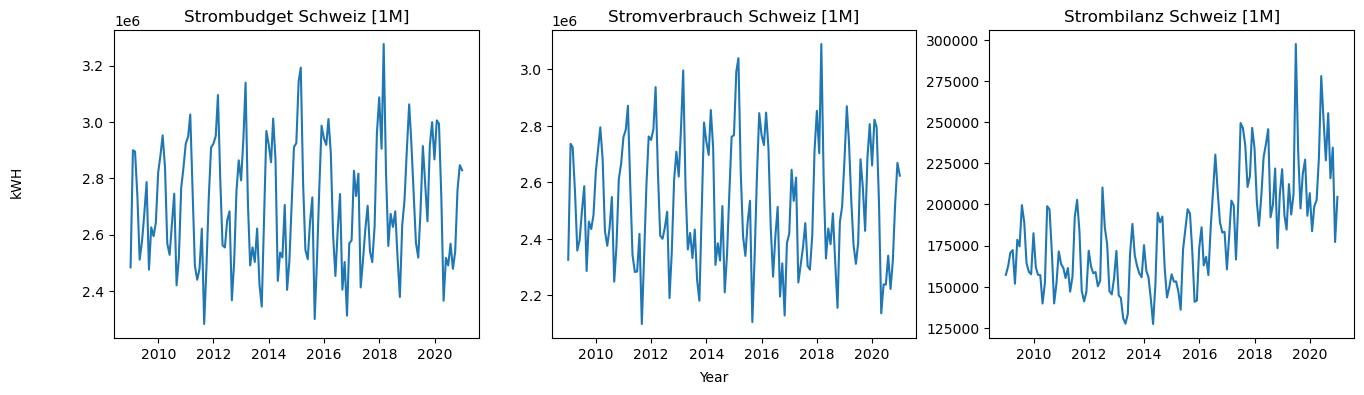

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16,4), sharex=True)
axs[0].plot(data_m['Strombudget Schweiz'])
axs[0].set_title('Strombudget Schweiz [1M]')
axs[1].plot(data_m['Stromverbrauch Schweiz'])
axs[1].set_title('Stromverbrauch Schweiz [1M]')
axs[2].plot(data_m['Strombilanz Schweiz'])
axs[2].set_title('Strombilanz Schweiz [1M]')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

##### Autokorrelation [1M]
Zunächst wollen wir uns die jährliche Saisonalität ansehen. Dies ist am einfachsten mit einer monatlichen Auflösung.

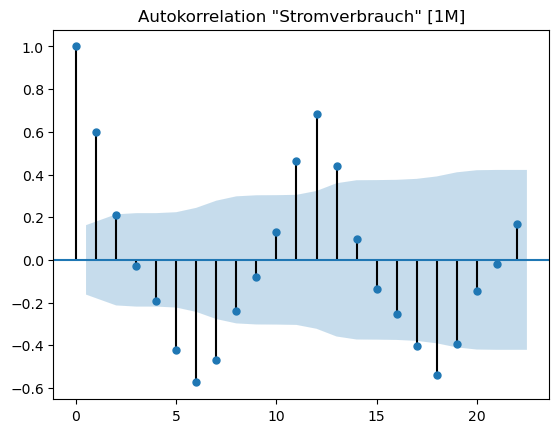

In [13]:
plot_acf(data_m['Stromverbrauch Schweiz'], title='Autokorrelation "Stromverbrauch" [1M]')
plt.show()

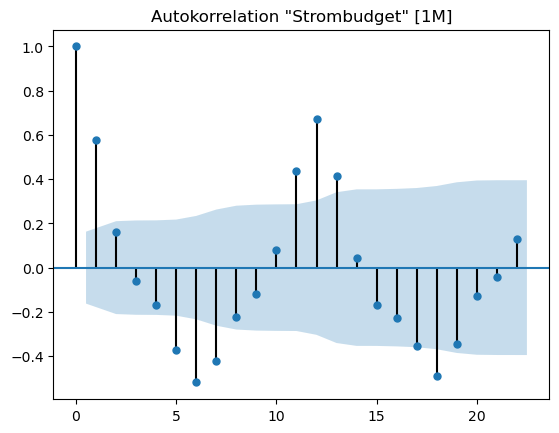

In [14]:
plot_acf(data_m['Strombudget Schweiz'], title='Autokorrelation "Strombudget" [1M]')
plt.show()

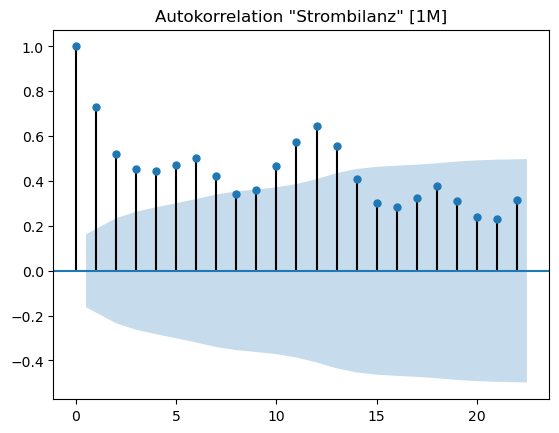

In [15]:
plot_acf(data_m['Strombilanz Schweiz'], title='Autokorrelation "Strombilanz" [1M]')
plt.show()

Wie erwartet, ist eine jährliche Saisonabhängigkeit des Strombudgets und des Stromverbrauchs zu beobachten. Auch die Bilanz scheint interessanterweise einem schwachen Jahreszyklus zu folgen. Wir können sehen, dass sie alle eine Spitze bei der Verzögerung von etwa 12 haben, was einem Jahr in Monaten entspricht.

#### 4 Stunden Daten
Bei den 4-Stunden-Daten werden wir uns mehr mit der täglichen Saisonalität befassen. Um diesen klarer zu sehen, schauen wir also jeweils nur mit einer Unterstichprobe der Gesamtdaten.

In [35]:
ROWS_TO_SHOW = 24

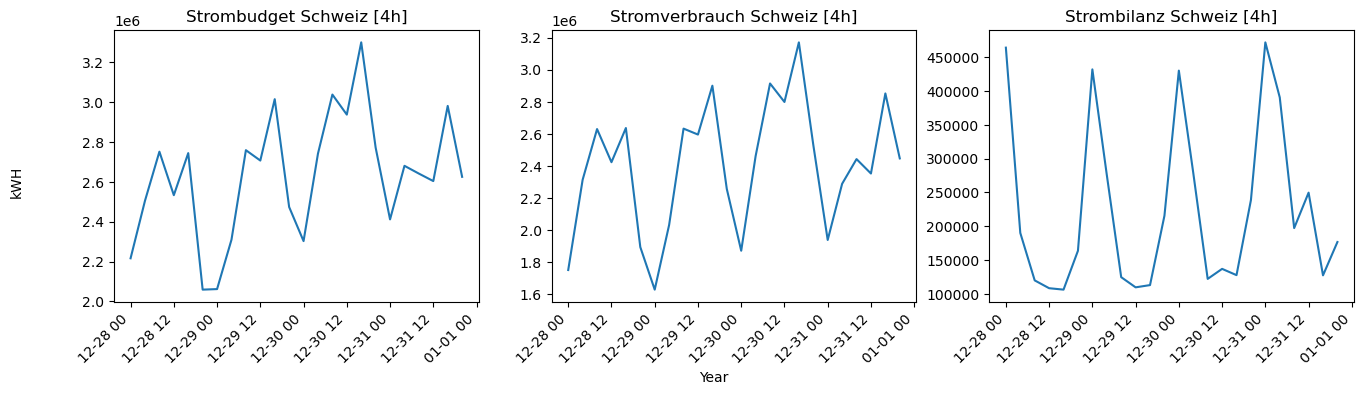

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(16,4), sharex=True)
axs[0].plot(data_4h['Strombudget Schweiz'].tail(ROWS_TO_SHOW))
axs[0].set_title('Strombudget Schweiz [4h]')
axs[1].plot(data_4h['Stromverbrauch Schweiz'].tail(ROWS_TO_SHOW))
axs[1].set_title('Stromverbrauch Schweiz [4h]')
axs[2].plot(data_4h['Strombilanz Schweiz'].tail(ROWS_TO_SHOW))
axs[2].set_title('Strombilanz Schweiz [4h]')
fig.autofmt_xdate(rotation=45)
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

#### 4-Stunden Daten, gemittelt über mehrere Jahre

In [53]:
data_4h_average = data_4h.copy()
data_4h_average['datetime'] = data_4h_average.index.strftime("%d-%m %H:%M")
data_4h_average = data_4h_average.groupby(data_4h_average.datetime).mean()

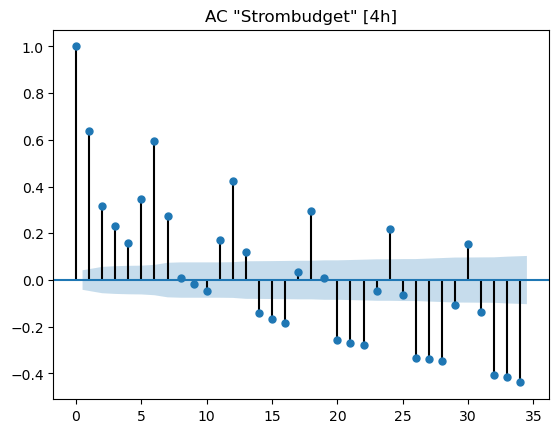

In [54]:
plot_acf(data_4h_average['Strombudget Schweiz'], title='AC "Strombudget" [4h]')
plt.show()

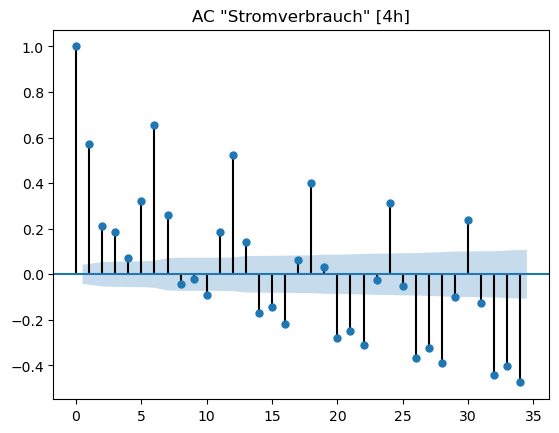

In [55]:
plot_acf(data_4h_average['Stromverbrauch Schweiz'], title='AC "Stromverbrauch" [4h]')
plt.show()

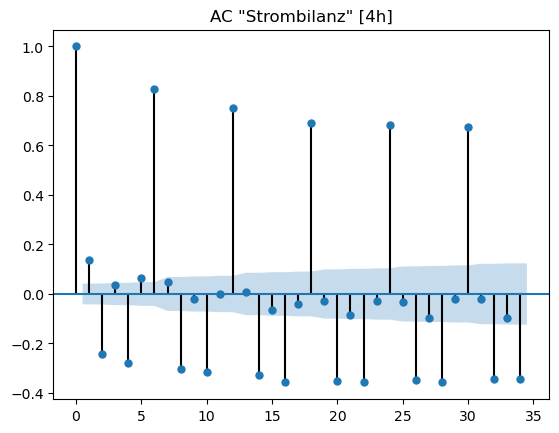

In [56]:
plot_acf(data_4h_average['Strombilanz Schweiz'], title='AC "Strombilanz" [4h]')
plt.show()

Es hat sich gelohnt, sich das auch unabhängig vom Jahr anzuschauen. Wir sehen hier den Lag von 6, was einem Tag entspricht.

### Saisonale Plots

Wir wollen unsere drei Messgrössen 'Stromverbrauch Schweiz', 'Strombudget Schweiz' und 'Strombilanz Schweiz' auf optische Unterschiede der Jährlichen Saisonalität untersuchen. 

Würden die Varianzen mit steigendem Erwartungswert zunehmen, deutet das darauf hin, dass ein multiplikatives Modell für die längerfristige Vorhersage potenziell besser geeignet wäre. Ist die Varianz unkorreliert vom Erwartungswert konstant, könnte hingegen ein additives Modell die bessere Wahl sein.

#### Stromverbrauch Schweiz

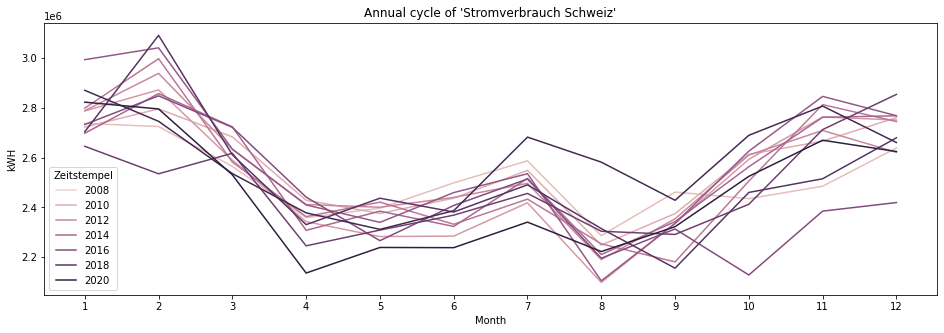

In [24]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=data_m, 
             x=data_m.index.month, 
             y="Stromverbrauch Schweiz", 
             hue=data_m.index.year)
ax.set_xticks(range(1,13))
plt.title("Annual cycle of 'Stromverbrauch Schweiz'")
plt.xlabel("Month")
plt.ylabel("kWH")
plt.show()

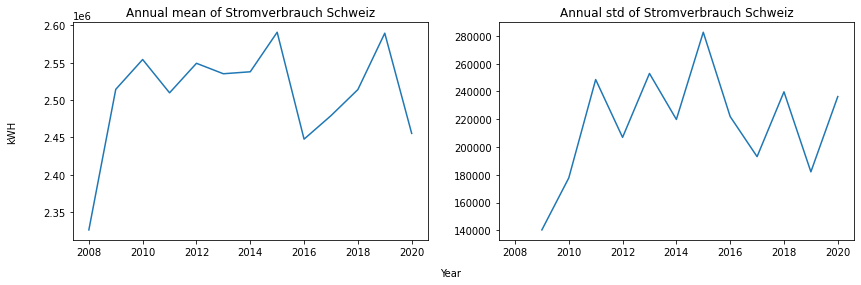

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
ax1.plot(data_m.groupby(data_m.index.year).mean()["Stromverbrauch Schweiz"])
ax1.set_title('Annual mean of Stromverbrauch Schweiz')
ax2.plot(data_m.groupby(data_m.index.year).std()["Stromverbrauch Schweiz"])
ax2.set_title('Annual std of Stromverbrauch Schweiz')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Es ist für uns nicht eindeutig erkennbar, ob ein additives oder multiplikatives Modell längerfristig zur vorhersage des Stromverbrauchs besser geeignet ist. Zwar scheint der Erwartungswert und die Standardabweichung in den Jahren 2008 und 2016 korreliert, nach 2016 ist das jedoch nicht mehr deutlich.

#### Strombudget Schweiz

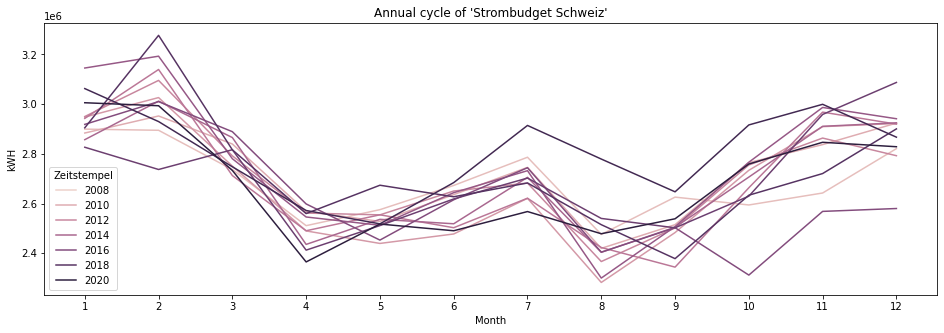

In [26]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=data_m, 
             x=data_m.index.month, 
             y="Strombudget Schweiz", 
             hue=data_m.index.year)
ax.set_xticks(range(1,13))
plt.title("Annual cycle of 'Strombudget Schweiz'")
plt.xlabel("Month")
plt.ylabel("kWH")
plt.show()

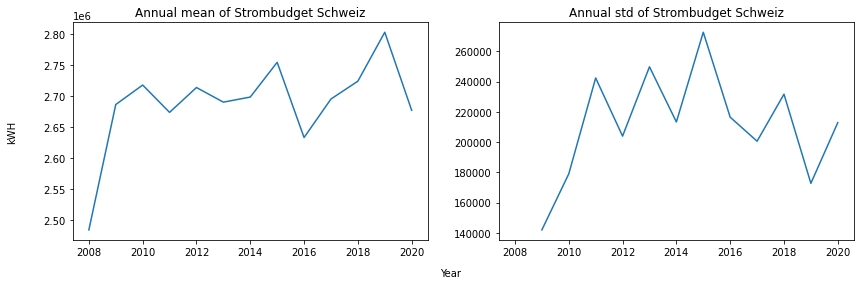

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
ax1.plot(data_m.groupby(data_m.index.year).mean()["Strombudget Schweiz"])
ax1.set_title('Annual mean of Strombudget Schweiz')
ax2.plot(data_m.groupby(data_m.index.year).std()["Strombudget Schweiz"])
ax2.set_title('Annual std of Strombudget Schweiz')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Auch hier ist für uns nicht eindeutig erkennbar, ob ein additives oder multiplikatives Modell längerfristig zur Vorhersage des Strombudgets besser geeignet ist. Die Korrelation zwischen Erwartungswert und Standardabweichung zeigt ein ähnliches Muster wie beim Stromverbrauch.

#### Strombilanz Schweiz

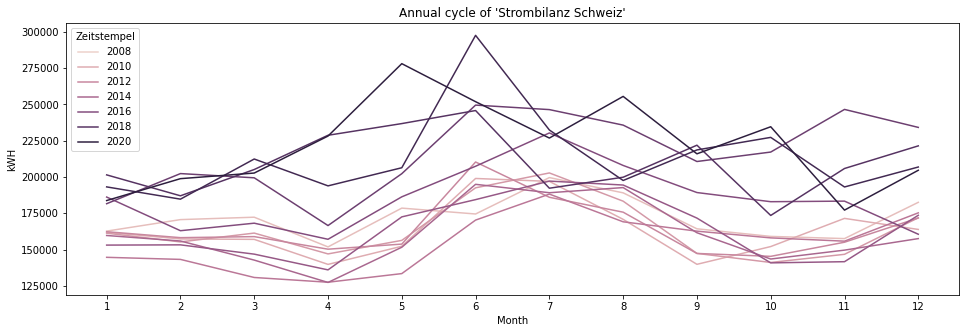

In [28]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=data_m, 
             x=data_m.index.month, 
             y="Strombilanz Schweiz", 
             hue=data_m.index.year)
ax.set_xticks(range(1,13))
plt.title("Annual cycle of 'Strombilanz Schweiz'")
plt.xlabel("Month")
plt.ylabel("kWH")
plt.show()

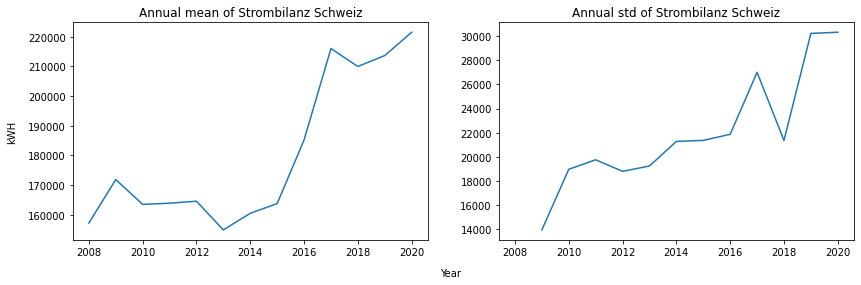

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
ax1.plot(data_m.groupby(data_m.index.year).mean()["Strombilanz Schweiz"])
ax1.set_title('Annual mean of Strombilanz Schweiz')
ax2.plot(data_m.groupby(data_m.index.year).std()["Strombilanz Schweiz"])
ax2.set_title('Annual std of Strombilanz Schweiz')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Bei der Strombilanz scheint eine Korrelation zwischen Erwartungswert und Standardabweichung vorhanden zu sein. Hier würden wir im Falle einer Vorhersage deshalb vermutlich ein multiplikatives Modell vorziehen.

## Train-Test Split

Um die Qualität unserer Vorhersagen ungefähr einschätzen zu können teilen wir diese in ein Trainings und Testset auf. Das Splitdatum ist der 31. Dez 2017 um 00:00 Uhr. Dadurch haben wir eine Zeitspanne von 9 Jahren im Trainingsset und 3 Jahre im Testset.

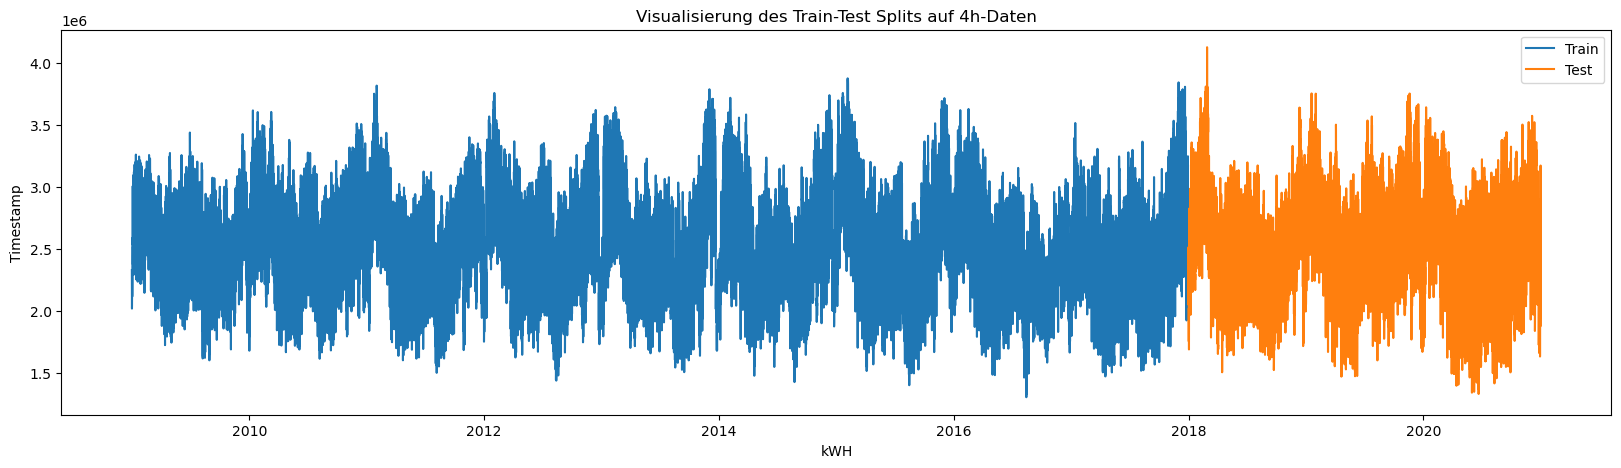

In [65]:
data_4h_train, data_4h_test = data_4h[:'2017-12-31 00:00:00+00:00'], data_4h['2017-12-31 00:00:00+00:00':]
data_d_train, data_d_test = data_d[:'2017-12-31 00:00:00+00:00'], data_d['2017-12-31 00:00:00+00:00':]
data_m_train, data_m_test = data_m[:'2017-12-31 00:00:00+00:00'], data_m['2017-12-31 00:00:00+00:00':]

plt.figure(figsize=(20,5))
plt.plot(data_4h_train["Stromverbrauch Schweiz"], label="Train")
plt.plot(data_4h_test["Stromverbrauch Schweiz"], label="Test")
plt.title("Visualisierung des Train-Test Splits auf 4h-Daten")
plt.xlabel("kWH")
plt.ylabel("Timestamp")
plt.legend()
plt.show()

### Zerlegung der 4-Stunden Daten

Hier zerlegen wir die 4-stündlichen Trainingsdaten. Dafür zerlegen wir die Daten zuerst in Bezug auf den Tageszyklus. Anschliessend wird dieser von der originalen 4-Stunden Zeitreihe herausgefiltert. Diese Prozedur wird anschliessend noch für die wöchentliche und jährliche Saisonalität wiederholt.

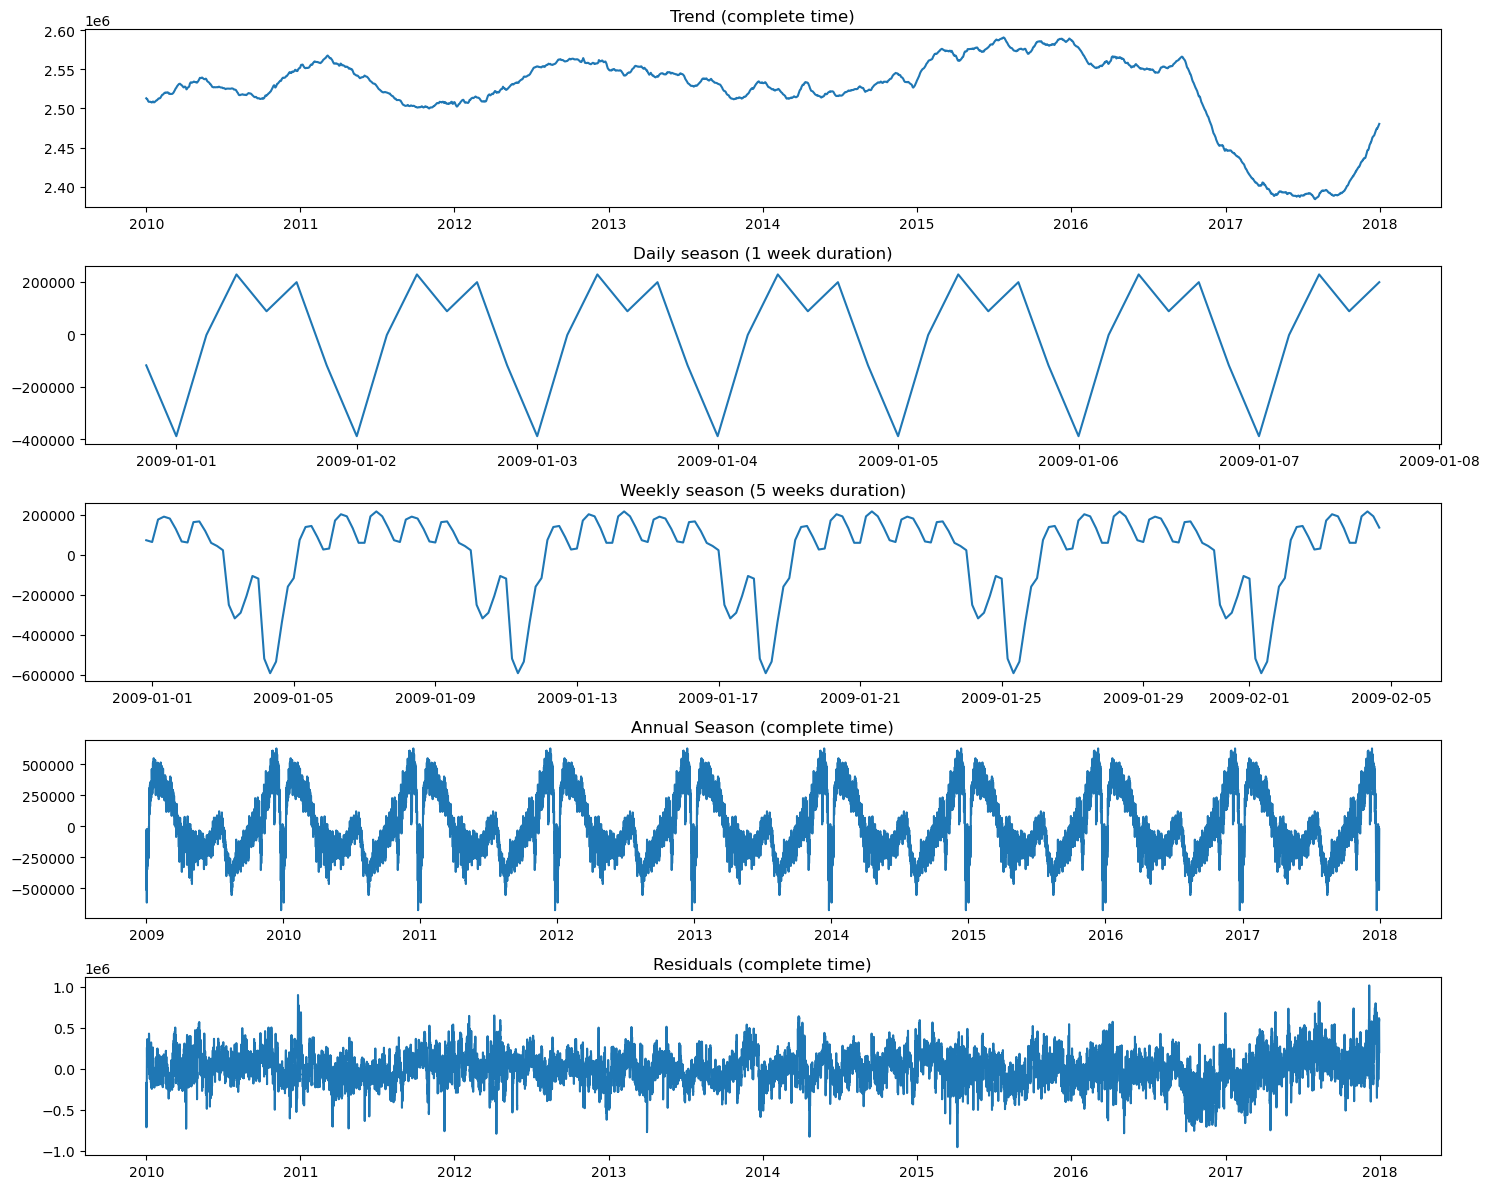

In [71]:
df = data_4h_train["Stromverbrauch Schweiz"]

# daily season
d = seasonal_decompose(df, period=6, model="additive", two_sided=False)
r = df - d.seasonal
# monthly season
w = seasonal_decompose(r, period=6*7, model="additive", two_sided=False)
r = r - w.seasonal
# annual season
a = seasonal_decompose(r, period=6*365, model="additive", two_sided=False)
r = r - a.seasonal

fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1, figsize=(15,12))
ax0.plot(a.trend)
ax1.plot(d.seasonal[0:6*7])
ax2.plot(w.seasonal[0:6*7*5])
ax3.plot(a.seasonal)
ax4.plot(a.resid)

ax0.title.set_text('Trend (complete time)')
ax1.title.set_text('Daily season (1 week duration)')
ax2.title.set_text('Weekly season (5 weeks duration)')
ax3.title.set_text('Annual Season (complete time)')
ax4.title.set_text('Residuals (complete time)')
fig.tight_layout()
plt.show()

Die Visualisierung zeigt die Zerlegung unserer 4-stündlichen Zeitreihe in einen Trend, Tägliche-, Wöchentliche-, und Jährliche Saisonalität. In einem nächsten Schritt schauen wir uns die daraus resultierenden Residuen an.

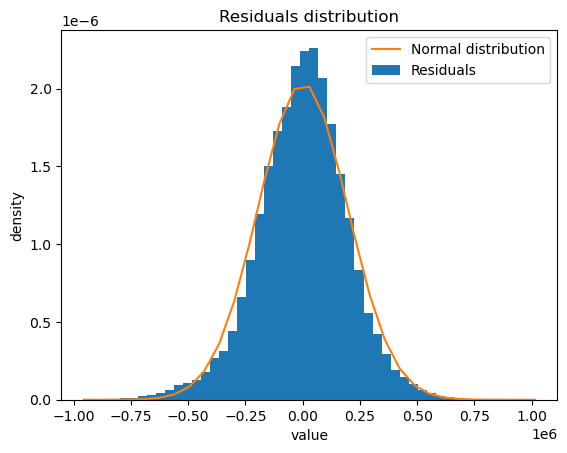

In [72]:
resid_std = a.resid.std()
resid_mean = a.resid.mean()

x = np.arange(a.resid.min(),a.resid.max(),int((a.resid.max()-a.resid.min())/30))
y = norm.pdf(x, resid_mean, resid_std)

plt.hist(a.resid, bins=50, density=True, label="Residuals")
plt.plot(x,y, label="Normal distribution")
plt.title("Residuals distribution")
plt.xlabel("value")
plt.ylabel("density")
plt.legend()
plt.show()

Die Residuen sind Normalverteilt, was uns zeig, das die saisonale Zerlegung erfolgreich war.

### Terndschätzung mittels linearer Regression.

Durch die saisonale Zerlegung haben wir den Trend als "Rolling mean" zurückerhalten. Unter der Annahme, dass dieser Trend über einen längeren Zeitraum linear ist und sich im bestehenden Muster weiterentwickelt, wollen wir nun für die Vorhersage des Trends mittels einer linearen Regression vornehmen. Da das Jahr 2017 ein Jahr war, an dem der Trend deutlich unter dem Erwartungswert der letzten Jahre lag und wir vermuten, es sich hier nicht um eine nachhaltige Entwicklung handelt, lassen wir dieses bei der Trendbildung weg.

In [73]:
start_date = '2008-12-31 20:00:00+00:00'
end_date = '2016-06-30 00:00:00+00:00'

mask = (a.trend.index > start_date) & (a.trend.index <= end_date)
trend = df.loc[mask].dropna()

X = np.arange(len(trend.dropna())).reshape(-1,1)
y = trend.dropna().values
reg = LinearRegression().fit(X, y)
trend_pred = reg.predict(np.arange(len(a.trend)).reshape(-1,1))

print("Intercept:", reg.intercept_)
print("Slope:", reg.coef_[0])

Intercept: 2522831.722586555
Slope: 2.2838447076242367


#### Rekonstruktion der Zeitreihe

Nun rekonstruieren wir die Zeitreihe auf dem Testset mittels linearen Trend und unseren Saisonalitäten.

In [74]:
original = data_4h_train["Stromverbrauch Schweiz"]
reconstructed = trend_pred + a.seasonal + w.seasonal + d.seasonal
data_4h_train_diff = original - reconstructed

#### Trainingsset

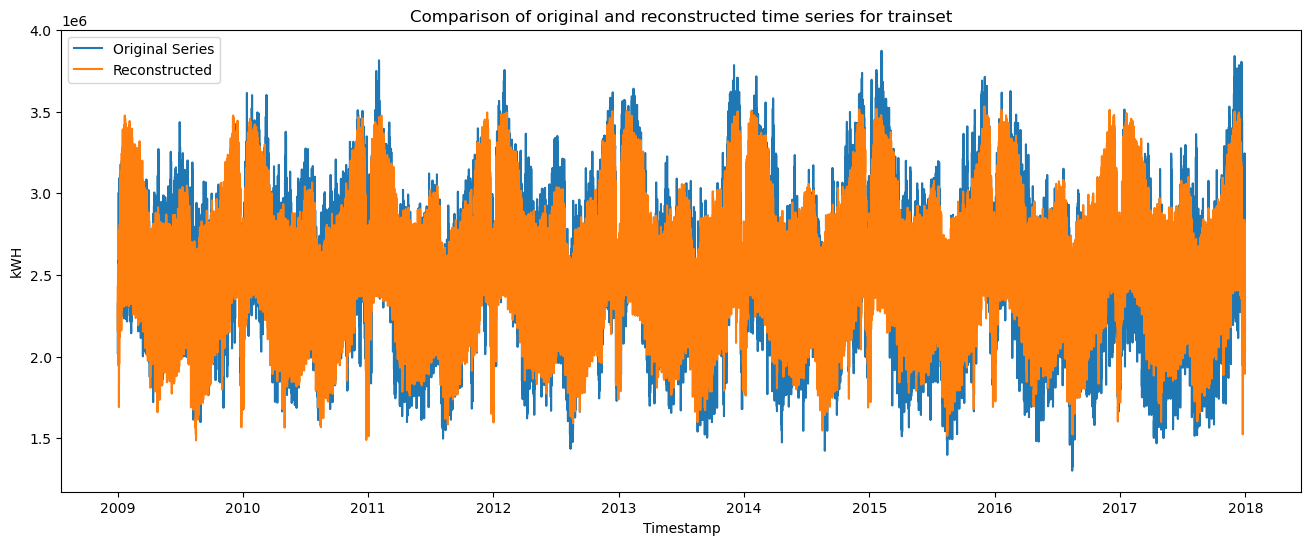

Mean avg percentage error: 0.06388920412817126
Mean squared error: 154577.02387125226


In [77]:
plt.figure(figsize=(16,6))
plt.plot(original, label="Original Series")
plt.plot(reconstructed, label="Reconstructed")
plt.legend()
plt.title("Comparison of original and reconstructed time series for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(original, reconstructed))
print("Mean absolute error:", mean_absolute_error(original, reconstructed))

In der Visualisierung sehen wir die tatsächliche Zeitreihe und die rekonstruierte Zeitreihe für das Trainings Set. Die rekonstruierte Zeitreihe hat einen durchschnittlichen prozentualen Fehler von 6.4 Prozent im Vergleich zur ursprünglichen Zeitreihe. Nun schauen wir uns noch die Qualität der Vorhersage auf dem Testset an.

#### Testset

In [78]:
predict_n_days = 365 * 20 # 20 Years
base = a.seasonal.index[1]

df_en_con = pd.DataFrame({"trend_pred":trend_pred, 
                          "annual_season":a.seasonal, 
                          "weekly_season":w.seasonal,
                          "daily_season":d.seasonal,})

for _ in range(6 * predict_n_days):
    df_en_con=df_en_con.append({"trend_pred":df_en_con.iloc[-1][0] - (df_en_con.iloc[-2][0] - df_en_con.iloc[-1][0]),
                     "annual_season":df_en_con.iloc[-365*6][1],
                     "weekly_season":df_en_con.iloc[-7*6][2],
                     "daily_season":df_en_con.iloc[-6][3]}, ignore_index=True)   
index_list=[]
for x in range(len(df_en_con)):
    index_list.append(base)
    base += datetime.timedelta(hours=4)
      
df_en_con["reconstructed"] = df_en_con["trend_pred"] + df_en_con["annual_season"] + df_en_con["weekly_season"] + df_en_con["daily_season"]

# Set index to timesamp
df_en_con["timestamp"] = index_list
df_en_con = df_en_con.set_index("timestamp")

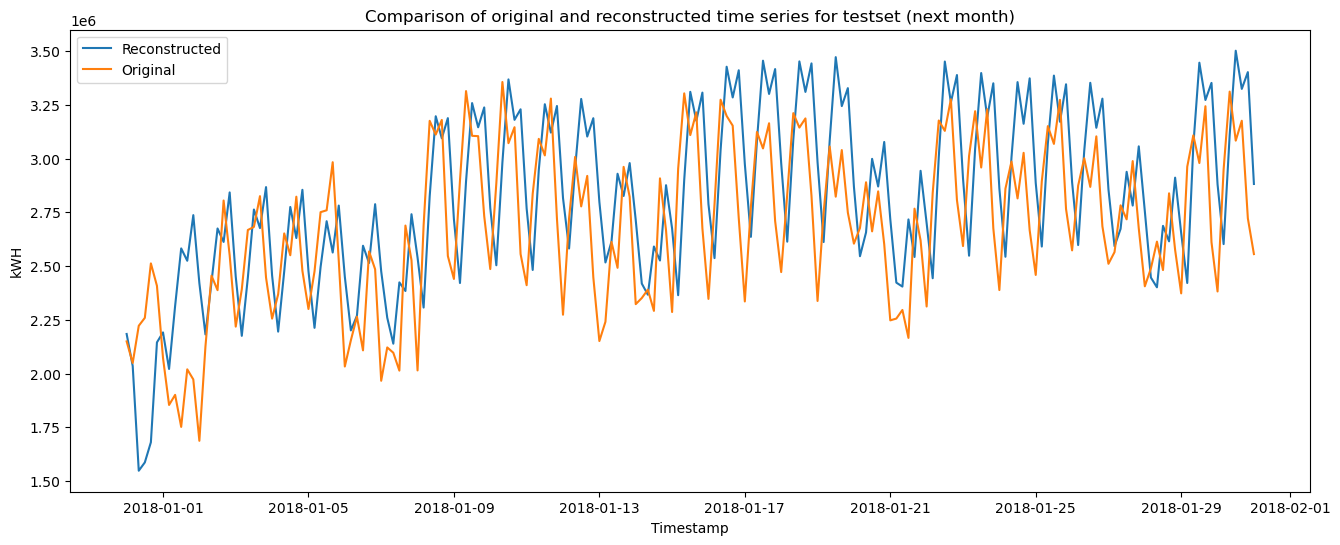

Mean avg percentage error: 0.11142826992054945
Mean squared error: 308700.9372731524


In [79]:
plt.figure(figsize=(16,6))
next_m_pred = df_en_con["reconstructed"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
next_m_is = data_4h_test["Stromverbrauch Schweiz"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
plt.plot(next_m_pred, label="Reconstructed")
plt.plot(next_m_is, label="Original")
plt.title("Comparison of original and reconstructed time series for testset (next month)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_m_pred, next_m_is))
print("Mean absolute error:", mean_absolute_error(next_m_pred, next_m_is))

In der Visualisierung sehen wir die tatsächliche Zeitreihe und die rekonstruierte Zeitreihe für den nächsten Monat. Die rekonstruierte Trainings-Zeitreihe hat einen durchschnittlichen prozentualen Fehler von 11.1 Prozent im Vergleich zur ursprünglichen Zeitreihe. Als nächstes überprüfen wir noch Fehler für das komplette Testset.

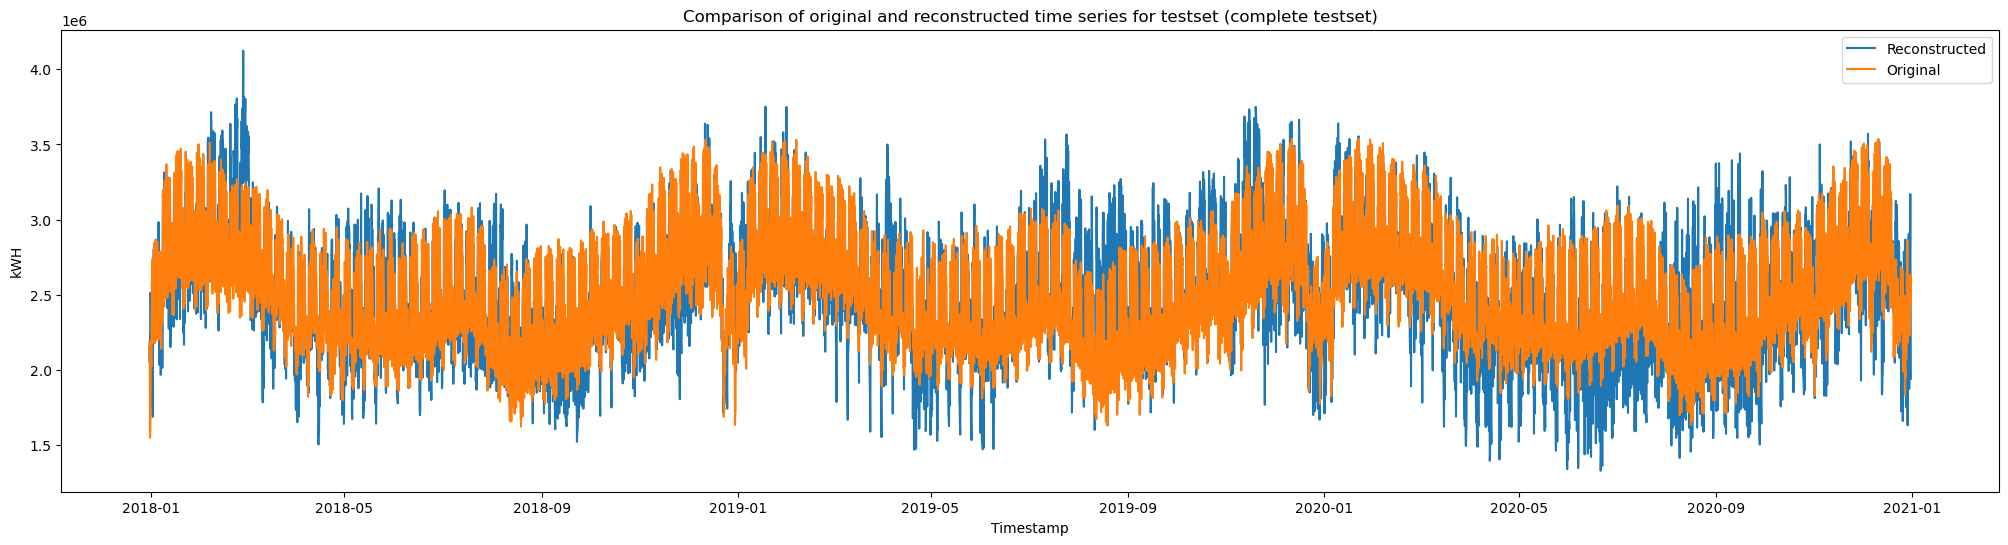

Mean avg percentage error: 0.13368620698524
Mean squared error: 334412.5711012484


In [80]:
plt.figure(figsize=(25,6))
next_3y_pred = df_en_con["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
next_3y_is = data_4h_test["Stromverbrauch Schweiz"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
plt.plot(next_3y_is, label="Reconstructed")
plt.plot(next_3y_pred, label="Original")
plt.title("Comparison of original and reconstructed time series for testset (complete testset)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_pred, next_3y_is))
print("Mean absolute error:", mean_absolute_error(next_3y_pred, next_3y_is))

In der Visualisierung sehen wir die tatsächliche Zeitreihe und die rekonstruierte Zeitreihe für das komplette Testset, was einer Dauer von 3 Jahren entspricht. Die rekonstruierte Trainings-Zeitreihe hat einen durchschnittlichen prozentualen Fehler von 13.3 Prozent im Vergleich zur ursprünglichen Zeitreihe. Der prozentuale Fehler hat sich im Vergleich zur 1-monatigen Vorhersage nur um 2.2 Prozentpunkte erhöht, weshalb wir diese einfache Methode als genau genug betrachten, um in einem nächsten Schritt mal 20 Jahre in die Zukunft zu modellieren.

#### Nächste 20 Jahre konstruieren

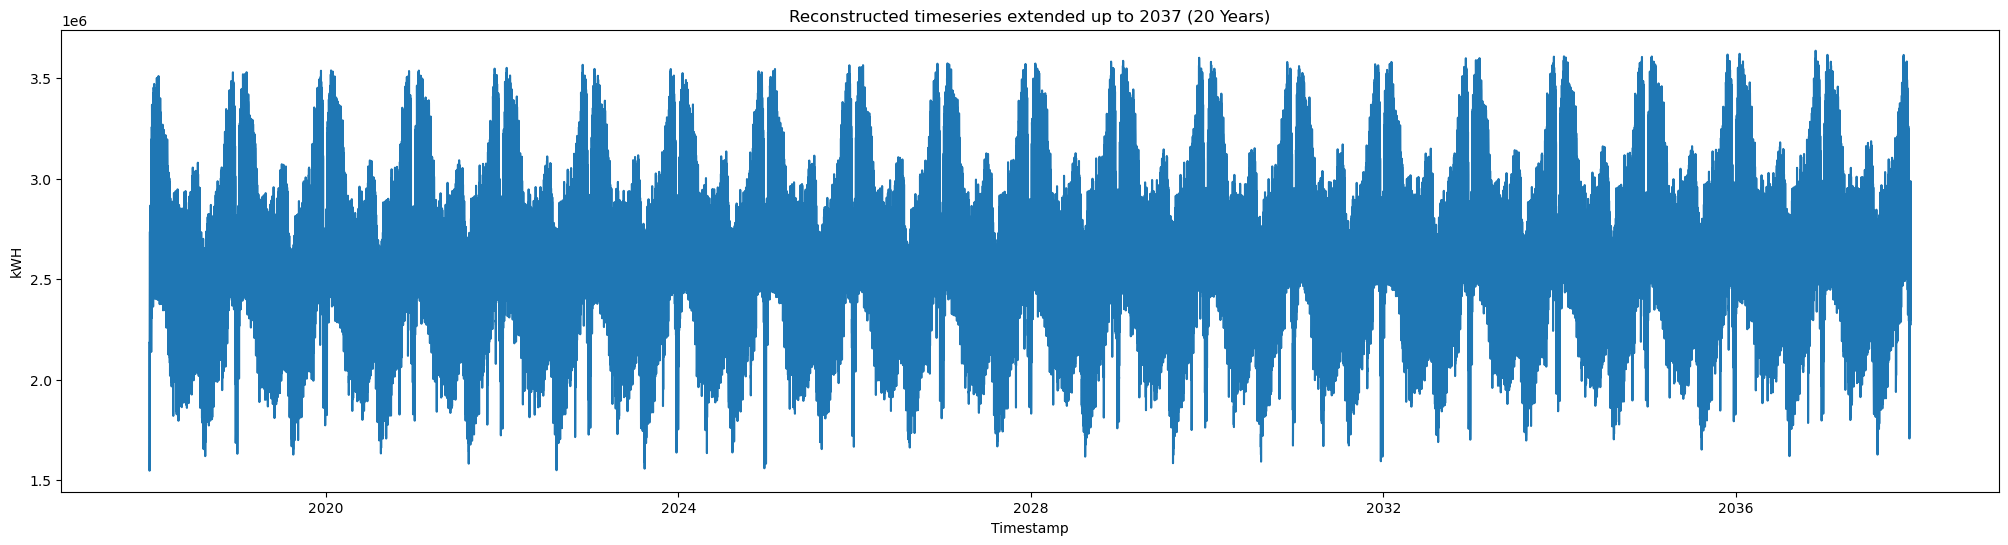

In [84]:
plt.figure(figsize=(25,6))
plt.title("Reconstructed timeseries extended up to 2037 (20 Years)")
plt.plot(df_en_con["reconstructed"]['2017-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00'])
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

Die Visualisierung zeigt die rekonstruierte Zeitreihe aus dem Trainingsset, wenn man die um 20 Jahre in die Zukunft erweitert unter der Annahme, dass sich der lineare Trend weiterführt und die saisonalen Komponenten gleich bleiben.

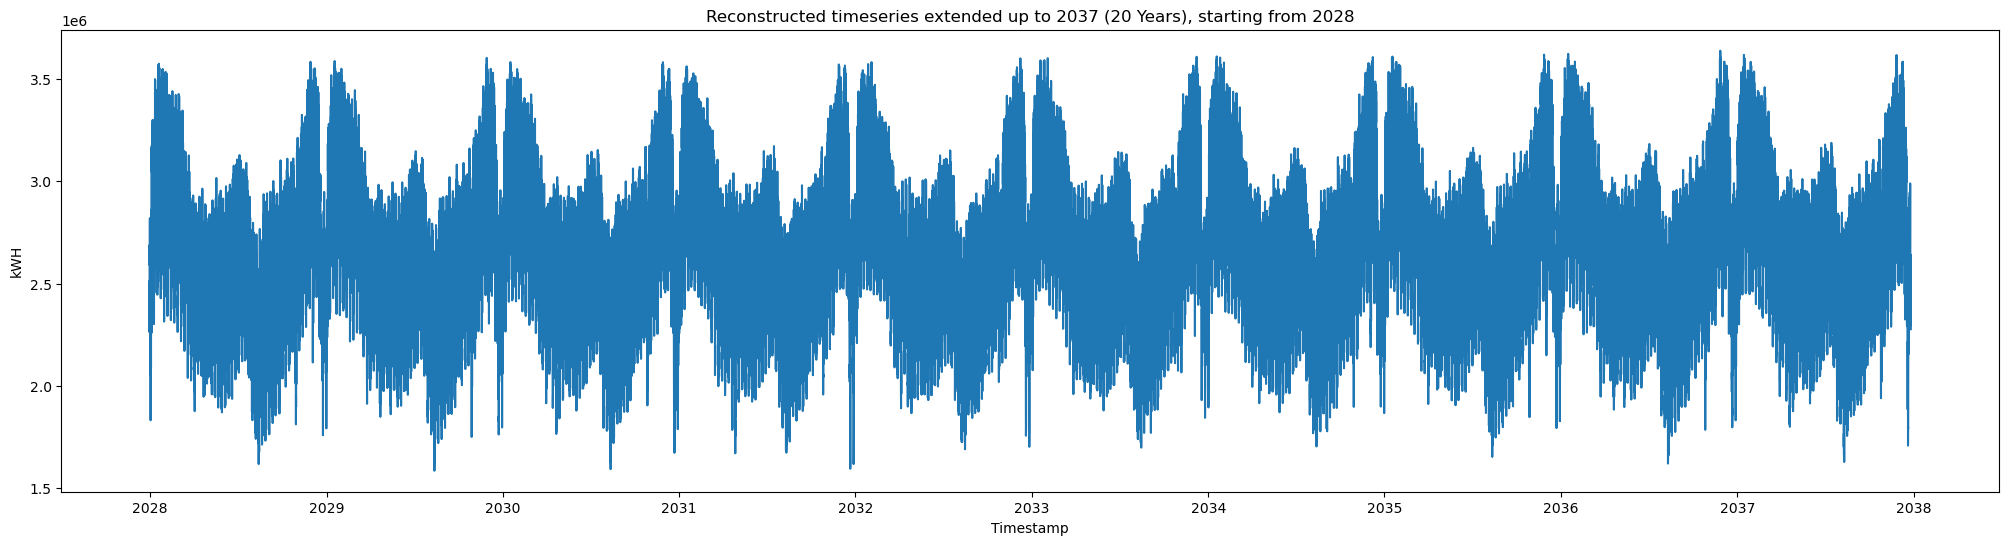

In [86]:
plt.figure(figsize=(25,6))
plt.title("Reconstructed timeseries extended up to 2037 (20 Years), starting from 2028")
plt.plot(df_en_con["reconstructed"]['2027-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00'])
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

## Arima Model

### Monthly data

In diesem Abschnitt erstellen wir ein einfaches Arima-Model auf den monatlichen Daten. Dafür untersuchen wir nochmals die Lags der monatlichen Trainingsdaten auf ihre Autokorrelation resp. partielle Autokorrelation.

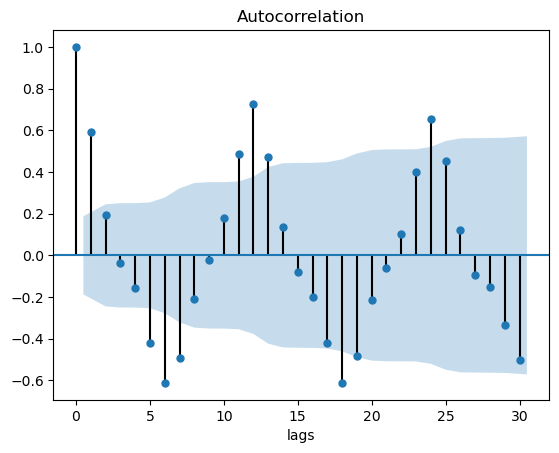

In [87]:
plot_acf(data_m_train["Stromverbrauch Schweiz"], lags=30)
plt.xlabel("lags")
plt.show()

Der Autokorrelationsplot zeigt einen signifikanten Lag. Deshalb wählen wir $q = 1$. Wir verzichten ausserdem auf eine Integration und wählen $d = 0$. Wir sehen zudem signifikante Lags alle 12 Monate.

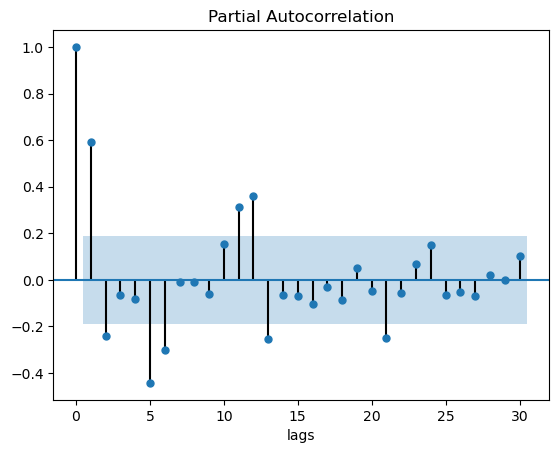

In [88]:
plot_pacf(data_m_train["Stromverbrauch Schweiz"], lags=30, method='ywm')
plt.xlabel("lags")
plt.show()

Der partielle Autokorrelationsplot zeigt zwei signifikante Lags. Deshalb wählen wir $p = 2$. Da ACF und PACF im 12-Monats-Zyklus ebenfalls signifikante Lags zeigen, wählen wir zusätzlich eine saisonale Komponente im ARIMA Modell mit $s=12$.

#### Training

In [48]:
model = ARIMA(data_m_train["Stromverbrauch Schweiz"], order=(2, 0, 1), seasonal_order=(2,1,1,12))
model_fit = model.fit()

C:\Users\samlu\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\samlu\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


#### Visualize fit

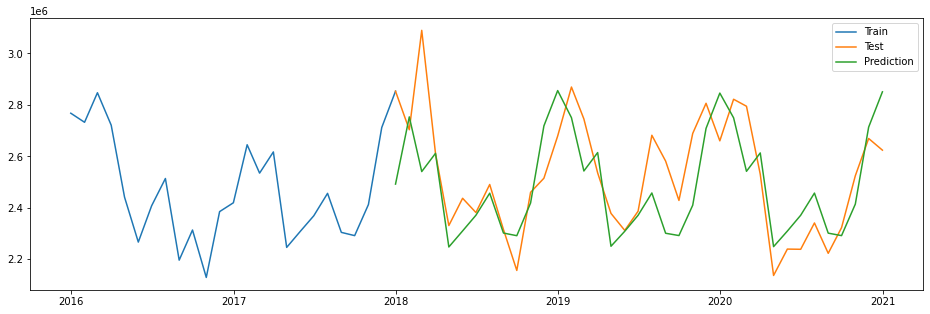

Mean avg percentage error: 0.05260841591788294
Mean squared error: 29642231990.813766


In [49]:
prediction = model_fit.predict('2017-12-31 00:00:00+00:00','2020-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.plot(data_m_train["Stromverbrauch Schweiz"]['2015-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_test["Stromverbrauch Schweiz"], label="Test")
plt.plot(prediction, label="Prediction")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(prediction, data_m_test["Stromverbrauch Schweiz"]))
print("Mean absolute error:", mean_absolute_error(prediction, data_m_test["Stromverbrauch Schweiz"]))

In der Visualisierung sehen wir die Trainings- und Testdaten als auch die Vorhersage mit unserem ARMA Model. Die Vorhersage hat zum Trainingsset eine mittlere Abweichung von 5.3 Prozentpunkten.

#### Voraussage nächste 20 Jahre

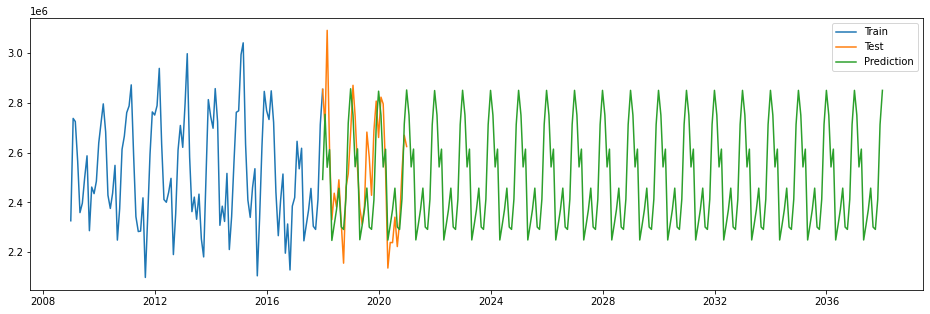

In [50]:
prediction = model_fit.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')
plt.figure(figsize=(16,5))
plt.plot(data_m_train["Stromverbrauch Schweiz"], label="Train")
plt.plot(data_m_test["Stromverbrauch Schweiz"], label="Test")
plt.plot(prediction, label="Prediction")
plt.legend()
plt.show()

#### Plot reconstructed Timeseries vs Arima prediction

Wir wollen nun überprüfen, wie ähnlich die rekonstruierte Zeitreihe und die Vorhersage unseres ARIMA Models sind. Dafür transformieren wir unsere 4-stündlich rekonstruierte Zeitreihe in monatliche Durchschnittswerte um.

Die nachfolgende Visualisierung zeigt diese monatlichen rekonstruierten Daten und stellt sie der Vorhersage unseres monatlichen ARIMA Models gegenüber.

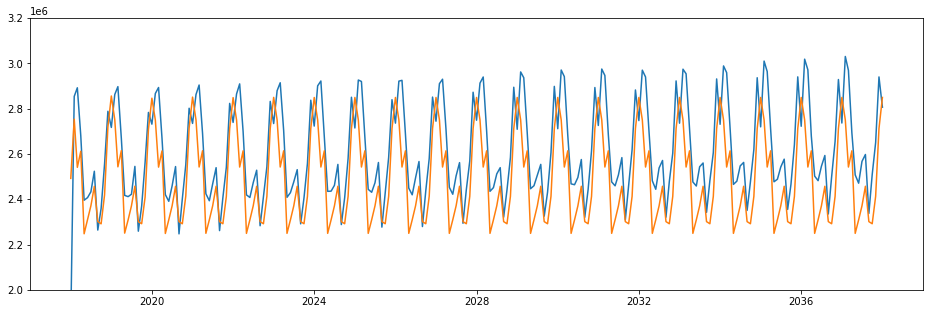

Mean avg percentage error: 0.062459802998869336
Mean squared error: 33308358160.12278


In [51]:
reconstructed = df_en_con["reconstructed"]['2017-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00']
reconstructed_m = reconstructed.resample('M').mean()

plt.figure(figsize=(16,5))
plt.plot(reconstructed_m)
plt.ylim(2.0e6, 3.2e6)
plt.plot(prediction)
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(prediction, reconstructed_m))
print("Mean absolute error:", mean_absolute_error(prediction, reconstructed_m))

### Daily data

Wie auch bei den monatlichen Daten möchten wir nun ein ARIMA Model auf den täglichen Daten erstellen. Dafür erstellen wir erneut ein ACF und PACF Plot.

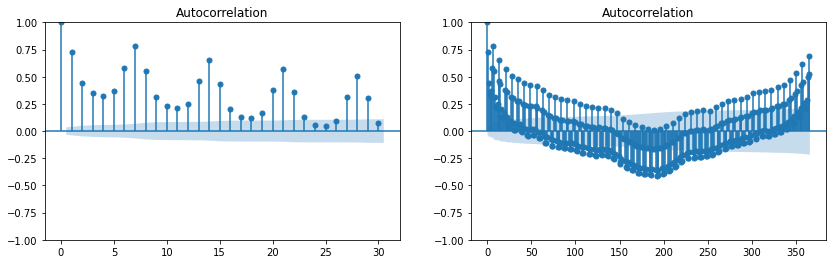

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=False)
plot_acf(data_d_train["Stromverbrauch Schweiz"], lags=30, ax=ax1)
plot_acf(data_d_train["Stromverbrauch Schweiz"], lags=365, ax=ax2)
plt.show()

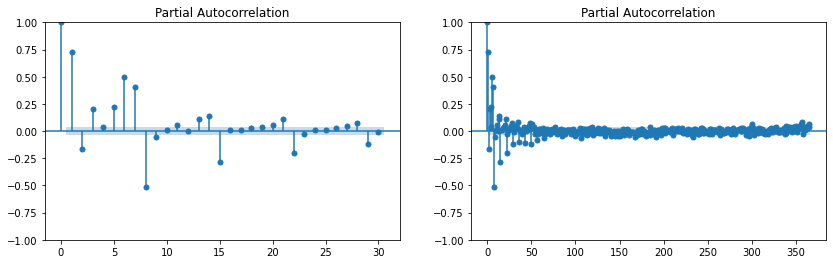

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=False)
plot_pacf(data_d_train["Stromverbrauch Schweiz"], lags=30, ax=ax1, method="ywm")
plot_pacf(data_d_train["Stromverbrauch Schweiz"], lags=365, ax=ax2, method="ywm")
plt.show()

In [92]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.api import SARIMAX, AutoReg

df = data_d_train["Stromverbrauch Schweiz"]

dayly_model = ARIMA(df, order=(1, 0, 1), seasonal_order=(1,0,1,365))
# dayly_model = SARIMAX(df, order=(0, 0, 0), seasonal_order=(1,0,1,365))
model_fit = dayly_model.fit()

prediction = model_fit.predict('2017-12-31 00:00:00+00:00','2020-12-31 00:00:00+00:00')

plt.figure(figsize=(16,7))
plt.plot(data_d_train["Stromverbrauch Schweiz"]['2016-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_d_test["Stromverbrauch Schweiz"], label="Test")
plt.plot(prediction, label="Prediction")
plt.legend()
plt.show()

KeyboardInterrupt: 

#### Wie oft reicht 10% der Spitzenproduktion nicht aus?
Dafür schauen wir uns die Produktion an und nehmen da das 10te Percentil an. Vom Verbrauch nehmen wir die gefundene Verteilung oben.

In [220]:
spitzenproduktion = data_4h['Strombudget Schweiz'].quantile(q=0.1)
spitzenproduktion

2194683.0195375

In [221]:
f'Wir müssen also schauen, wie oft die Produktion von {spitzenproduktion} KWH nicht ausreicht'

'Wir müssen also schauen, wie oft die Produktion von 2194683.0195375 KWH nicht ausreicht'

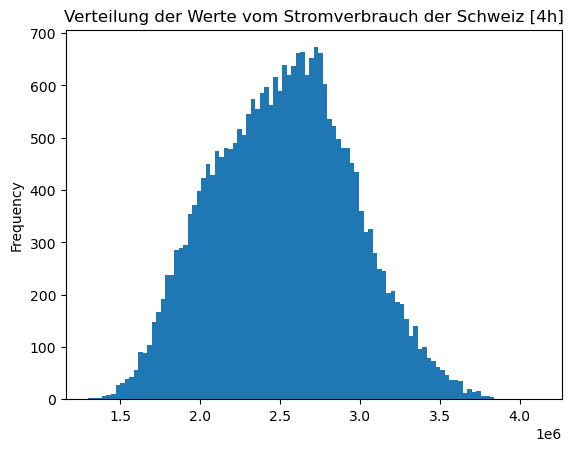

In [222]:
data_4h['Stromverbrauch Schweiz'].copy().plot.hist(bins=100, title='Verteilung der Werte vom Stromverbrauch der Schweiz [4h]')
plt.show()

Es sieht Normalverteilt aus. Das überprüfen wir mit dem QQ-Plot:

Best dist: norm


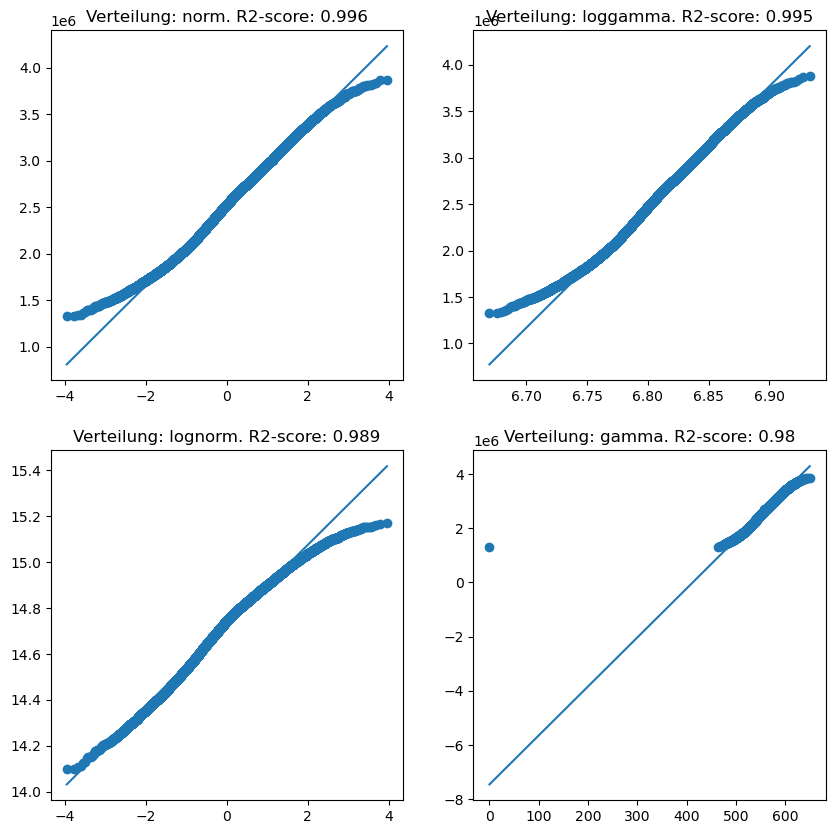

In [223]:
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.lognorm, stats.gamma, stats.norm, stats.loggamma]

r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, data_4h['Stromverbrauch Schweiz'])
plt.show()

Eigentlich wäre die beste Verteilung die Normalverteilung. Uns interessieren aber hauptsächlich die unteren Werte und da sehen wir, dass die Lognormal-Verteilung die beste ist. Somit nehmen wir diese.

In [224]:
dist_args = best_dist.fit(data_4h['Stromverbrauch Schweiz'])
best_dist.cdf(spitzenproduktion, *dist_args)

0.22533579487280414

Wir sehen also, dass 10% der Spitzenproduktion in 22.5% der 4h Stunden Intervalle ausreicht.

### Extremwertanalyse Strombilanz Schweiz
Nun schauen wir uns die Extremwerte der Bilanz an.

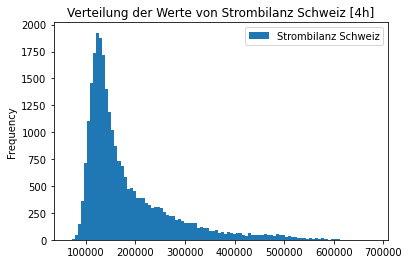

In [71]:
data_4h[['Strombilanz Schweiz']].copy().plot.hist(bins=100, title='Verteilung der Werte von Strombilanz Schweiz [4h]')
plt.show()

Es sieht definitiv logarithmisch aus. Wir schauen uns also Verteilungen an, welche einen Longtail haben. Ebenfalls interessieren uns Extremwerte im niedrigen Bereich. Die Verteilung "Weibull Min" könnte also passend sein.

In [203]:
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.lognorm,stats.norm, stats.weibull_min, stats.loggamma]


In [192]:
data_idx = np.where(data_4h['Strombilanz Schweiz'].values > np.quantile(data_4h['Strombilanz Schweiz'].values , 0.9))[0]
data = data_4h['Strombilanz Schweiz'].values[data_idx]

Best dist: lognorm


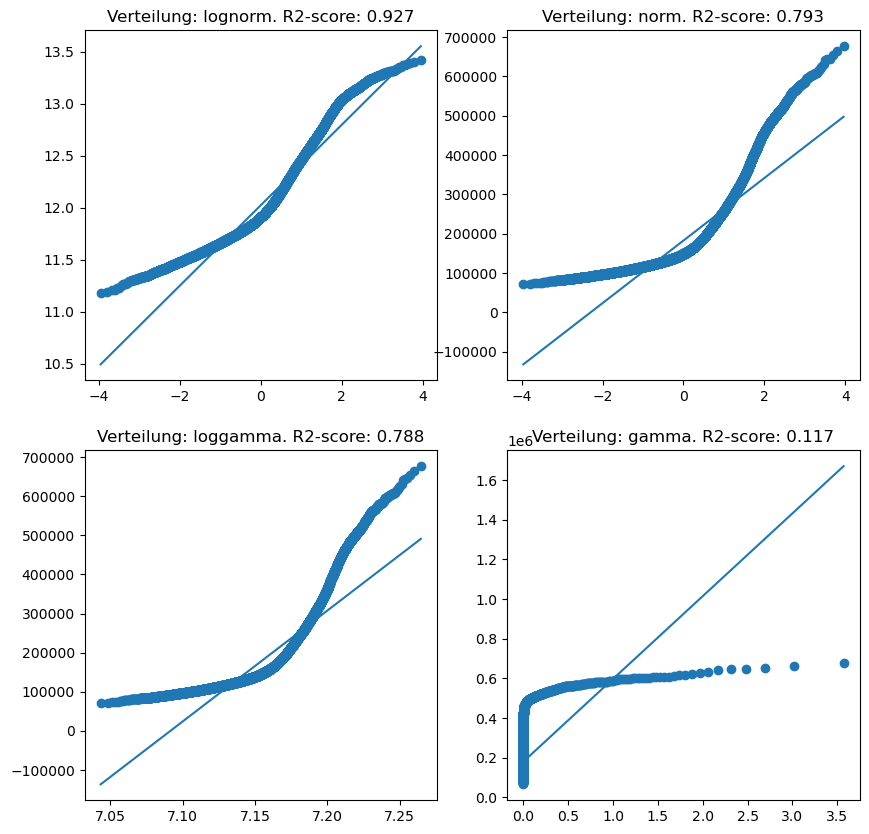

In [234]:
r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, data_4h['Strombilanz Schweiz'], quantile_for_gev=0.1)
plt.show()

Die Weibull-Verteilung ist die beste.

In [241]:
# fit parameters to data
PERCENT_OF_VALUES = 0.999
distargs = best_dist.fit(data_4h['Strombilanz Schweiz'])

array([171605.13298152,  92267.08101094, 136666.91060247, ...,
       269015.68496528, 335084.81416757, 237779.75108052])

In [243]:
f"In {100*(PERCENT_OF_VALUES)}% der 4-Stunden Zeitabschnitte wird die Strombilanz der Werte unter dem 10ten Perzentil im Intervall {best_dist.interval(PERCENT_OF_VALUES, *distargs)}KMH sein."

'In 99.9% der 4-Stunden Zeitabschnitte wird die Strombilanz der Werte unter dem 10ten Perzentil im Intervall (76400.3439330865, 859009.001406444)KMH sein.'